In [1]:
# default_exp io

# Zarr

<br>

### Imports

In [4]:
#export
import pandas as pd
import xarray as xr
import numpy as np
import dask
import zarr
import gcsfs
import numcodecs
from ipypb import track

from satip import eumetsat, reproj

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.10rows/s]


In [5]:
import os
import dotenv

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from IPython.display import JSON

<br>

### User Inputs

In [6]:
data_dir = '../data/raw'
metadata_db_fp = '../data/EUMETSAT_metadata.db'
debug_fp = '../logs/EUMETSAT_download.txt'
new_grid_fp='../data/intermediate/new_grid_4km_TM.json'
new_coords_fp = '../data/intermediate/reproj_coords_TM_4km.csv'

in_zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr'
out_zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/full_extent_TM_int16'

<br>

### Loading Environment Variables

In [7]:
dotenv.load_dotenv('../.env')

user_key = os.environ.get('USER_KEY')
user_secret = os.environ.get('USER_SECRET')
slack_id = os.environ.get('SLACK_ID')
slack_webhook_url = os.environ.get('SLACK_WEBHOOK_URL')

<br>

### Preparing Data to Save to Zarr

We'll start by loading in one of the datasets we've just downloaded, in this instance we'll take the most recent one by identifying it from the metadata db.

In [8]:
dm = eumetsat.DownloadManager(user_key, user_secret, data_dir, metadata_db_fp, debug_fp)

df_metadata = dm.get_df_metadata()

df_metadata.tail()

2021-01-08 09:43:50,879 - INFO - ********** Download Manager Initialised **************


,start_date,end_date,result_time,platform_short_name,platform_orbit_type,instrument_name,sensor_op_mode,center_srs_name,center_position,file_name,file_size,missing_pct,downloaded
id,,,,,,,,,,,,,
332,2020-01-01 00:00:07.683,2020-01-01 00:04:14.102,2020-01-01 00:04:14.102,MSG3,GEO,SEVIRI,RSS,EPSG:4326,0 9.5,MSG3-SEVI-MSG15-0100-NA-20200101000414.1020000...,99819,0.0,2021-01-07 20:39:02.727875
333,2020-01-01 00:05:08.795,2020-01-01 00:09:15.215,2020-01-01 00:09:15.215,MSG3,GEO,SEVIRI,RSS,EPSG:4326,0 9.5,MSG3-SEVI-MSG15-0100-NA-20200101000915.2150000...,99819,0.0,2021-01-07 20:40:35.463153
334,2020-01-01 00:10:09.908,2020-01-01 00:14:16.328,2020-01-01 00:14:16.328,MSG3,GEO,SEVIRI,RSS,EPSG:4326,0 9.5,MSG3-SEVI-MSG15-0100-NA-20200101001416.3280000...,99819,0.0,2021-01-07 20:42:01.806167
335,2020-01-01 00:15:11.021,2020-01-01 00:19:17.440,2020-01-01 00:19:17.440,MSG3,GEO,SEVIRI,RSS,EPSG:4326,0 9.5,MSG3-SEVI-MSG15-0100-NA-20200101001917.4400000...,99819,0.0,2021-01-07 20:42:42.769446
336,2021-01-07 20:50:09.828,2021-01-07 20:54:16.209,2021-01-07 20:54:16.209,MSG3,GEO,SEVIRI,RSS,EPSG:4326,0 9.5,MSG3-SEVI-MSG15-0100-NA-20210107205416.2090000...,99819,0.0,2021-01-07 21:37:09.110106


<br>

We'll then load in the file

In [9]:
filename = df_metadata.loc[df_metadata.index[-2], 'file_name']
native_fp = f'{data_dir}/{filename}.nat'

severi_area_def = reproj.get_seviri_area_def(native_fp)
seviri_crs = severi_area_def.to_cartopy_crs()

scene = reproj.load_scene(native_fp)
scene.load(['HRV'])

/Users/laurence/software/anaconda3/envs/satip_dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/Users/laurence/software/anaconda3/envs/satip_dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


<br>

And visualise it to test that everything is working

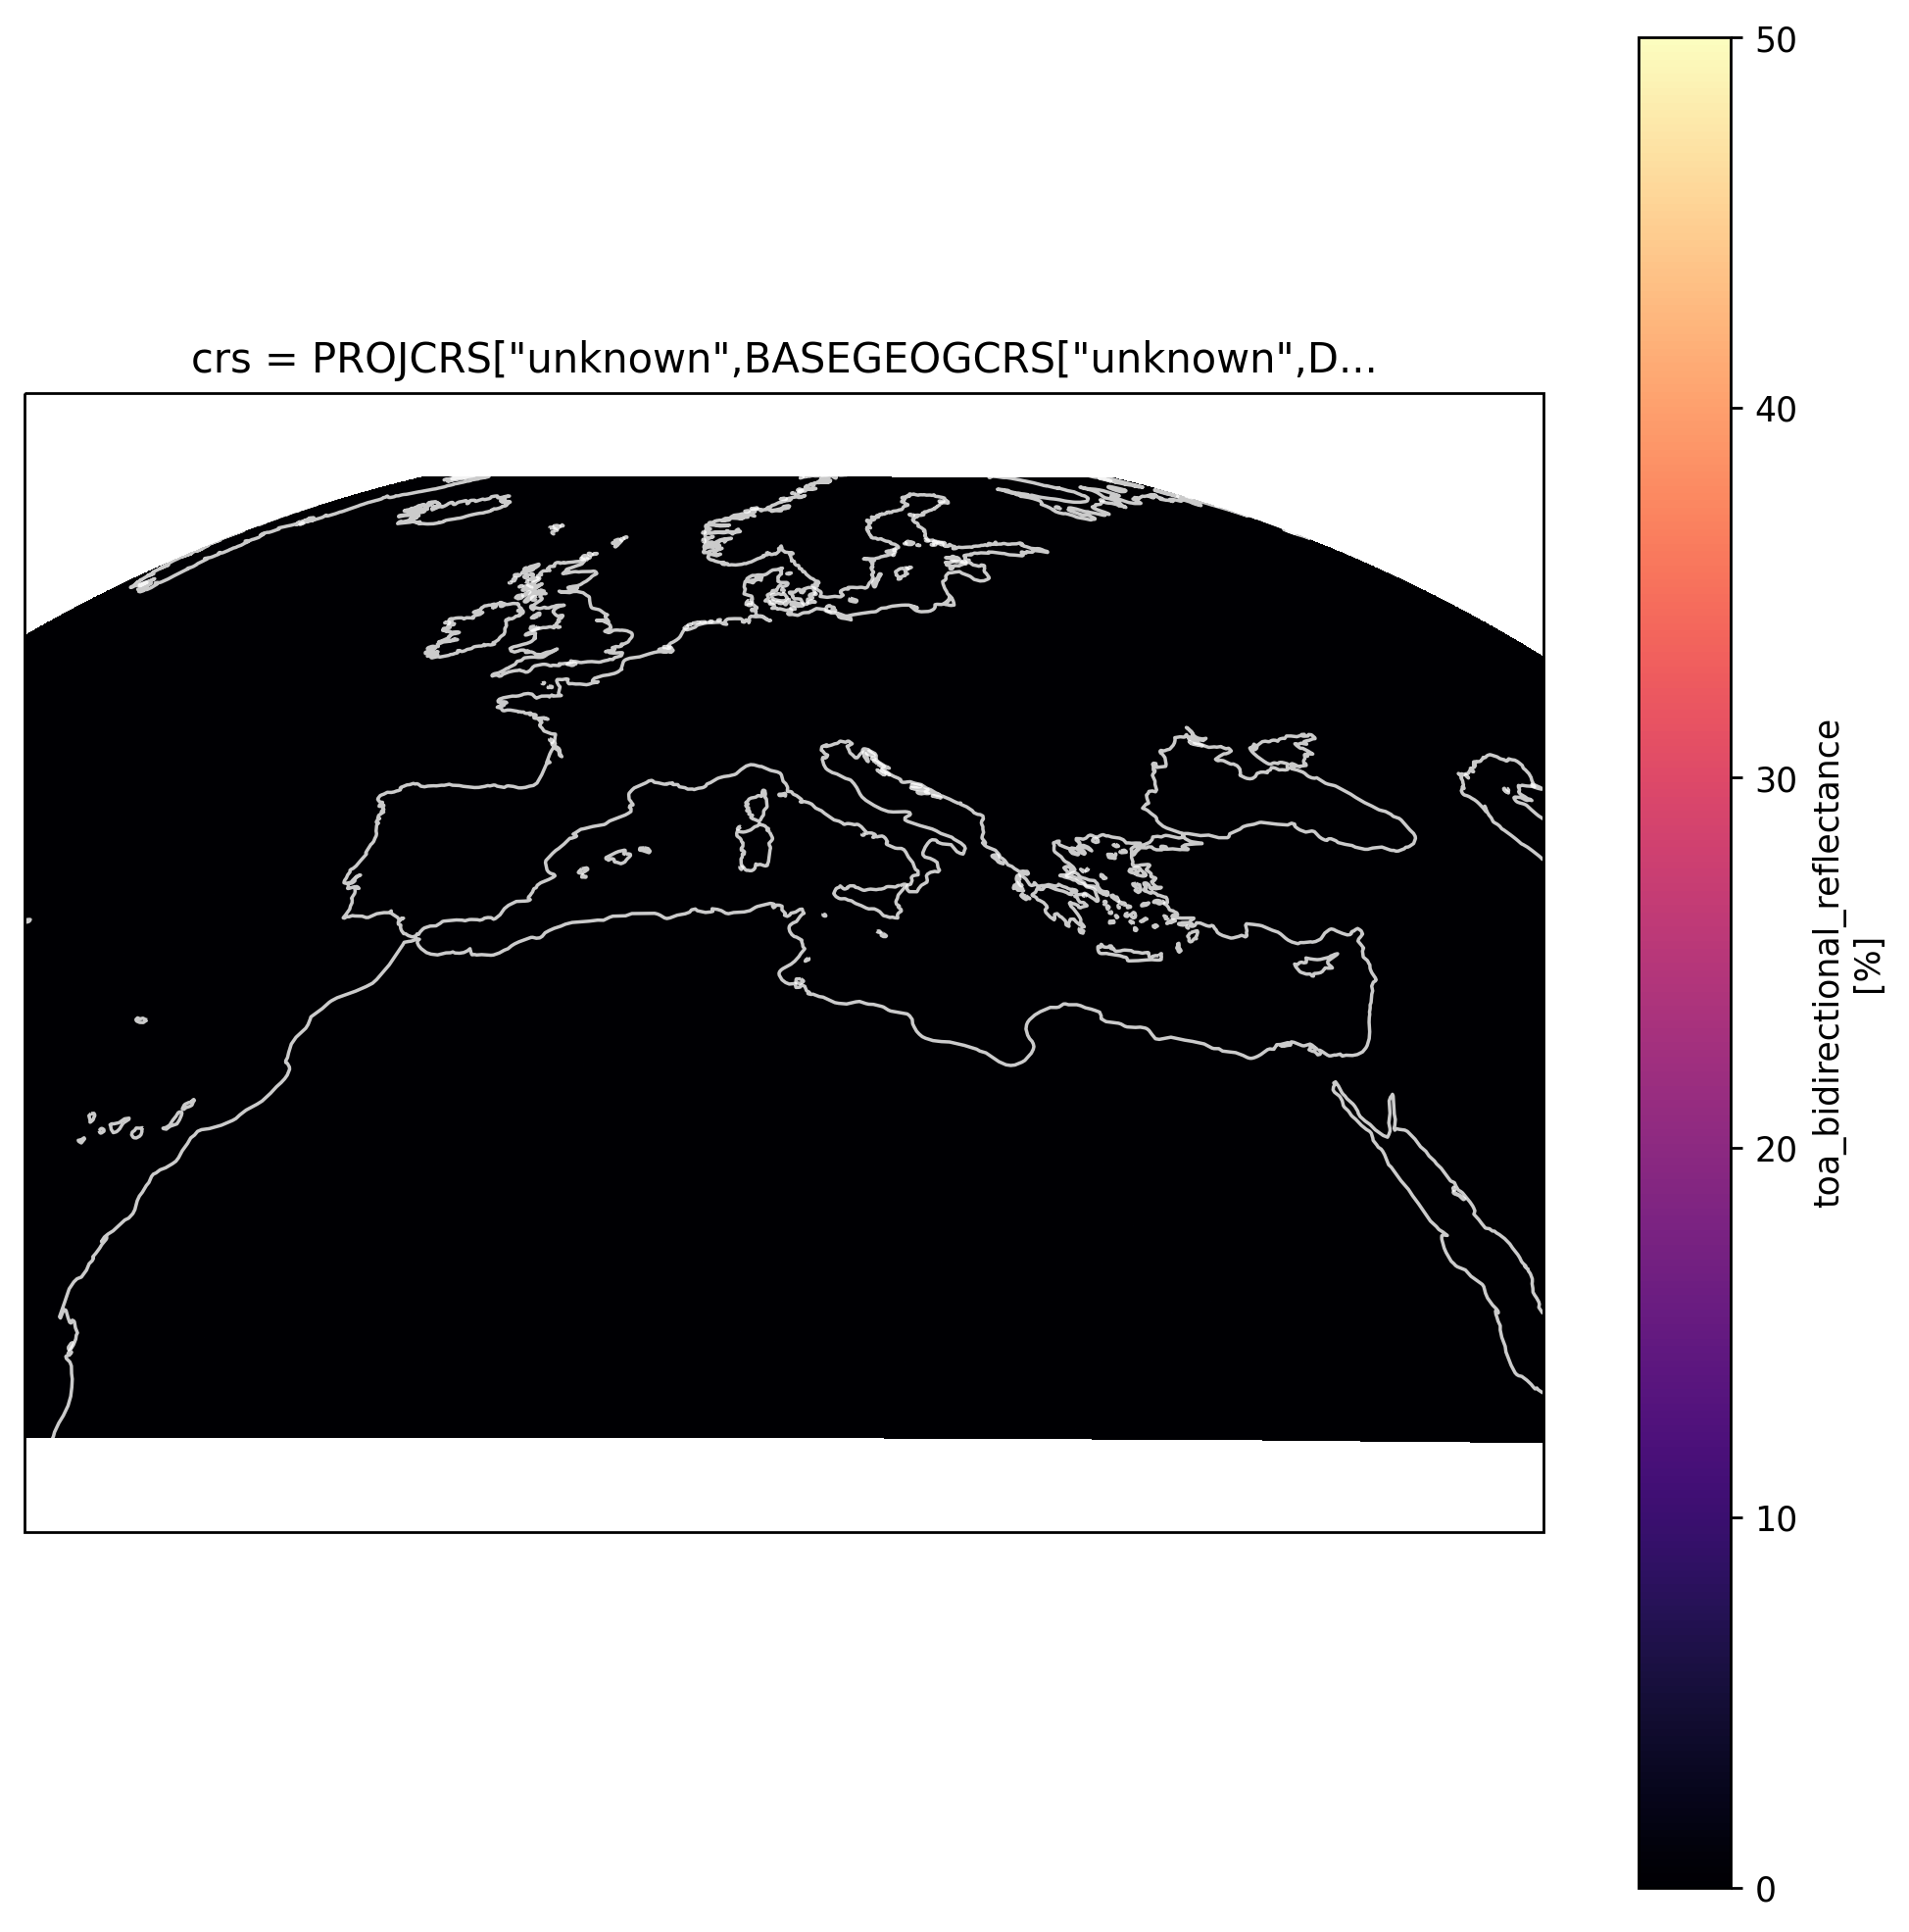

In [10]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=seviri_crs)

scene['HRV'].plot.imshow(ax=ax, cmap='magma', vmin=0, vmax=50)

ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

We now need to reproject it

In [11]:
%%capture --no-stdout
%%time

reprojector = reproj.Reprojector(new_coords_fp, new_grid_fp)
ds_reproj = reprojector.reproject(native_fp, reproj_library='pyresample')

CPU times: user 4.79 s, sys: 356 ms, total: 5.14 s
Wall time: 5.41 s


<br>

Which again we'll check through visualisation

<ipython-input-12-53f177b0781d>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())
/Users/laurence/software/anaconda3/envs/satip_dev/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/Users/laurence/software/anaconda3/envs/satip_dev/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


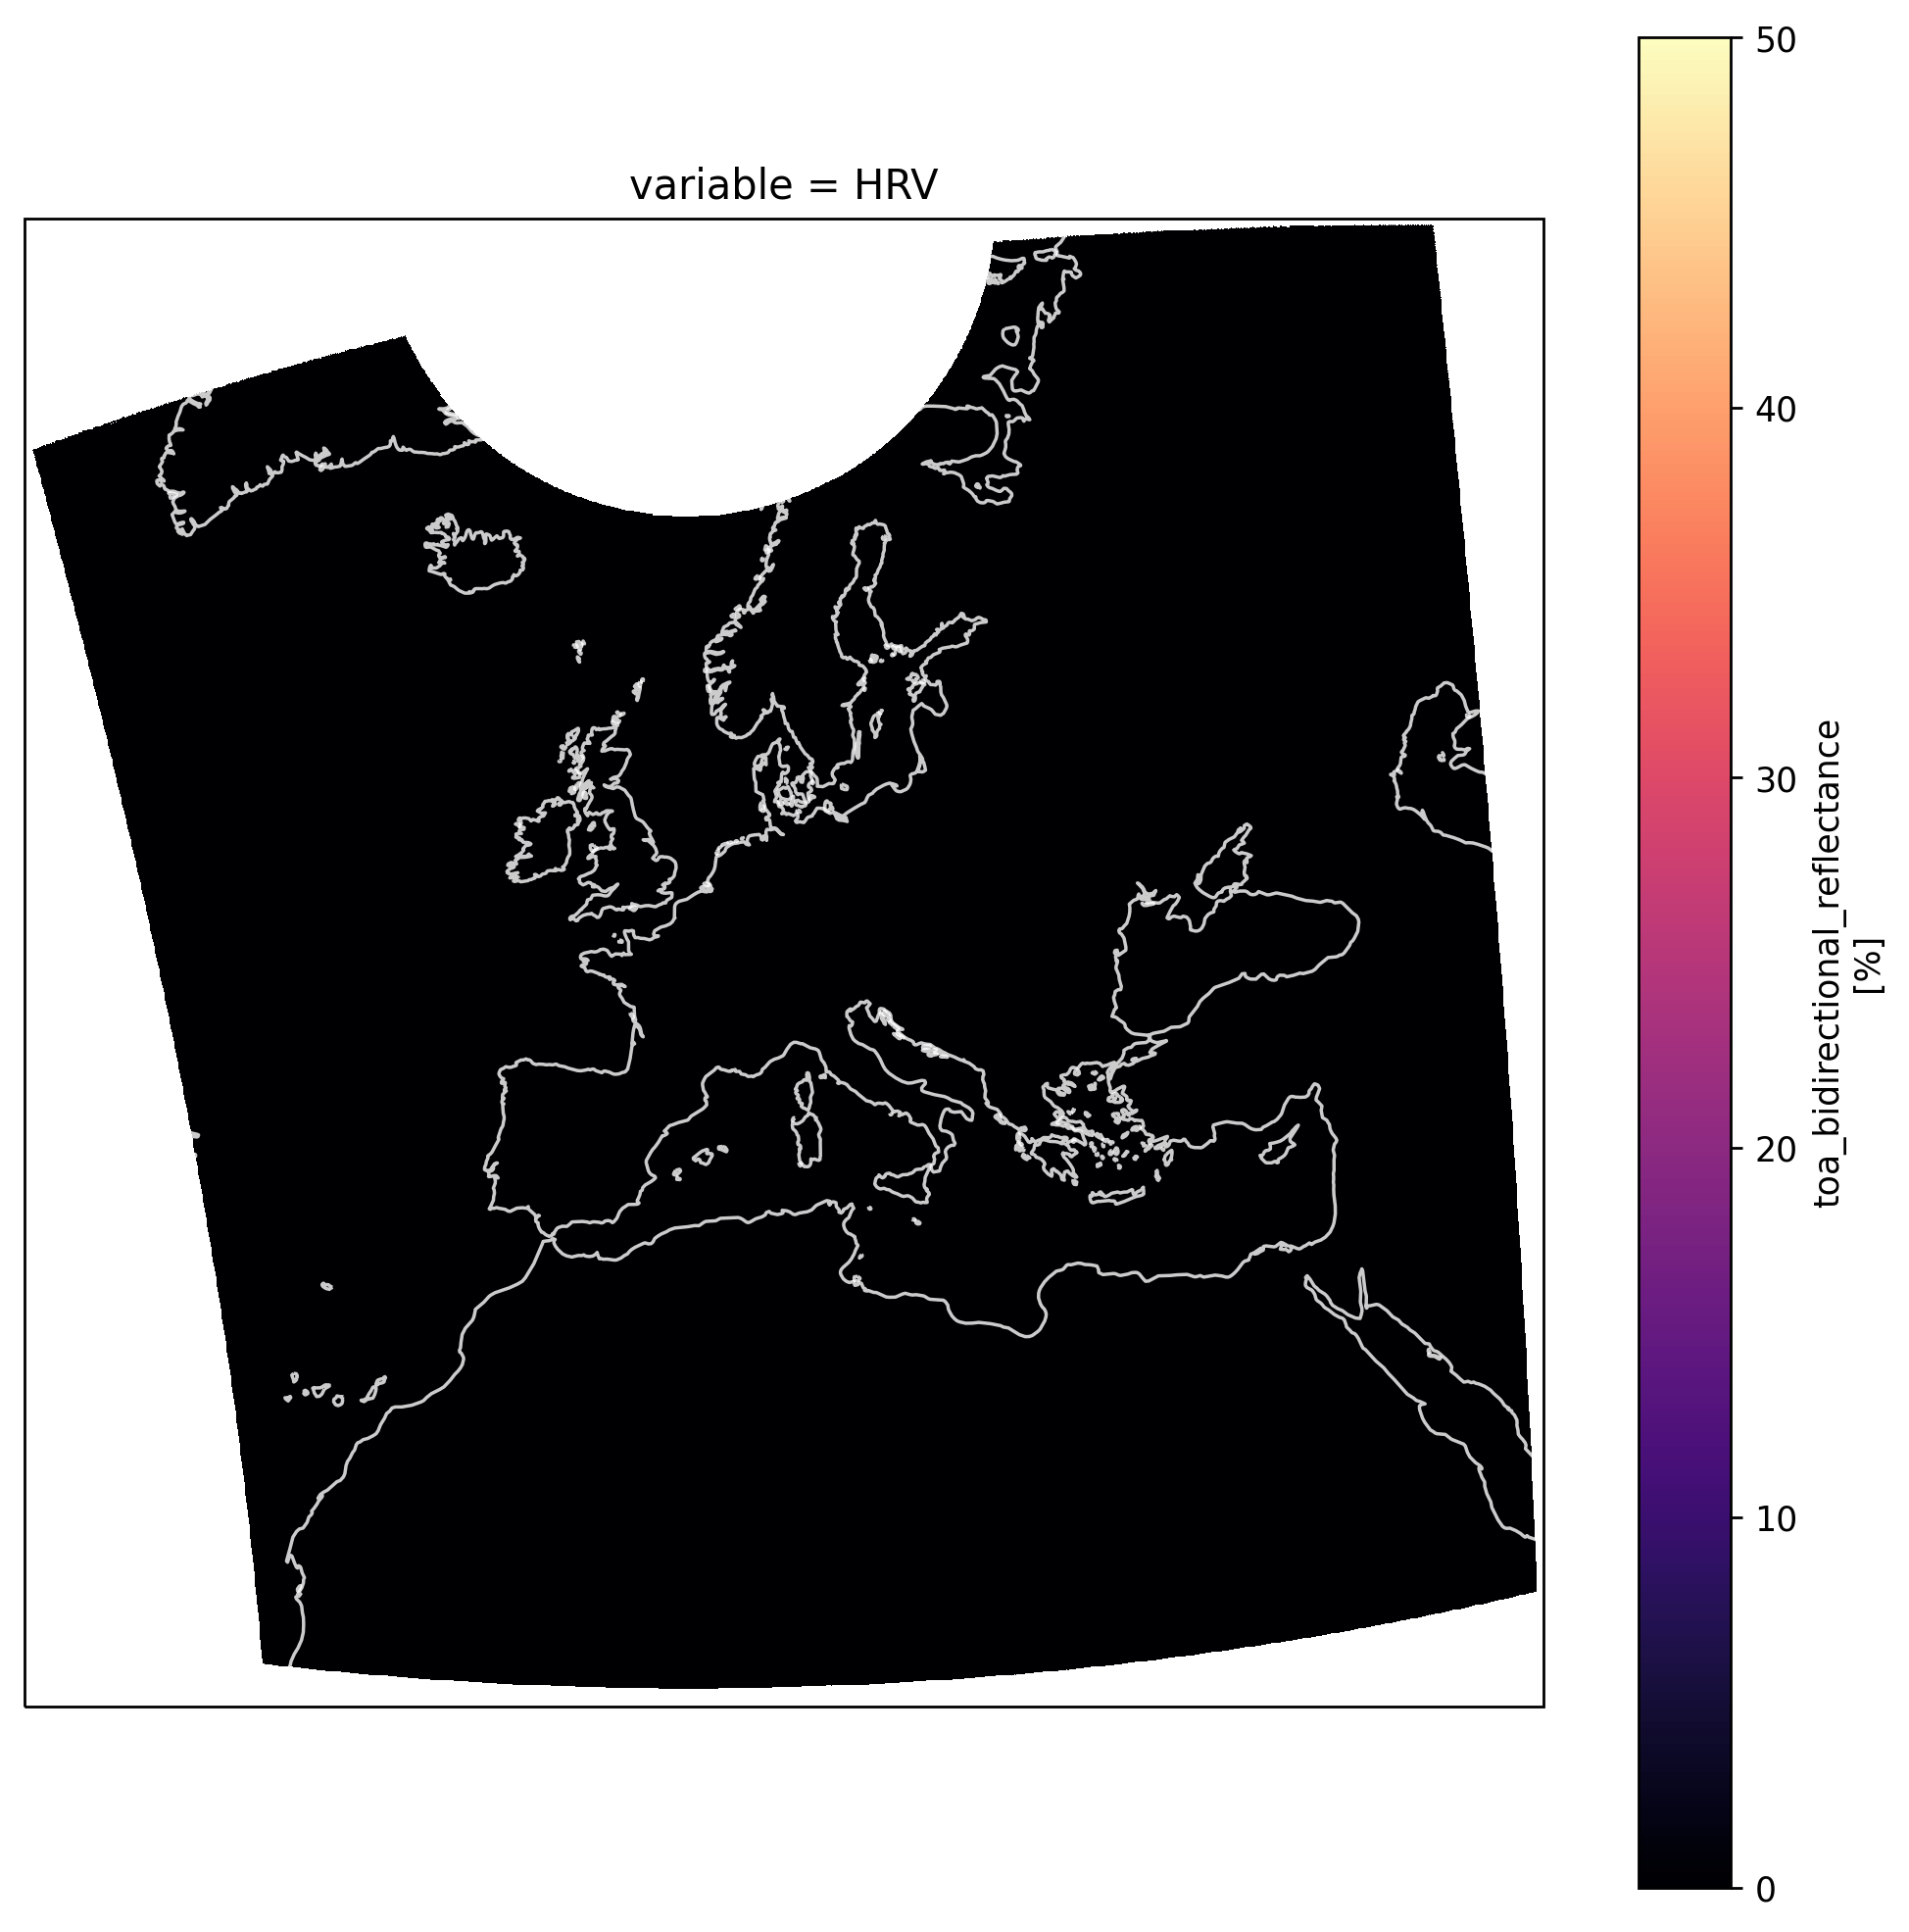

In [12]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

ds_reproj['stacked_eumetsat_data'].sel(variable='HRV').plot.imshow(ax=ax, cmap='magma', vmin=0, vmax=50)

ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

### Compressing

We'll now develop our compressor class that will reduce the size of the datasets that we save to Zarr, in this instance we'll normalize the data and transform it to Int16. This has been found to reduce the size by ~50%.

In [13]:
#exports
def add_constant_coord_to_da(da, coord_name, coord_val):
    """
    Adds a new coordinate with a 
    constant value to the DataArray
    
    Parameters
    ----------
    da : xr.DataArray
        DataArrray which will have the new coords added to it
    coord_name : str
        Name for the new coordinate dimensions
    coord_val
        Value that will be assigned to the new coordinates
        
    Returns
    -------
    da : xr.DataArray
        DataArrray with the new coords added to it
    
    """
    
    da = (da
          .assign_coords({coord_name:coord_val})
          .expand_dims(coord_name)
         )
    
    return da

class Compressor:
    def __init__(self, 
                 bits_per_pixel=10, 
                 mins=np.array([-1.2278595, -2.5118103, -64.83977, 63.404694, 2.844452, 199.10002, -17.254883, -26.29155, -1.1009827, -2.4184198, 199.57048, 198.95093]), 
                 maxs=np.array([103.90016, 69.60857, 339.15588, 340.26526, 317.86752, 313.2767, 315.99194, 274.82297, 93.786545, 101.34922, 249.91806, 286.96323]),
                 variable_order=['HRV', 'IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073']
                ):
        
        locals_ = locals()
        attrs_to_add = ['bits_per_pixel', 'mins', 'maxs', 'variable_order']
        
        for attr in attrs_to_add:
            setattr(self, attr, locals_[attr])
            
        return
    
    def fit(self, da, dims=['time', 'y', 'x']):
        self.mins = da.min(dims).compute()
        self.maxs = da.max(dims).compute()
        self.variable_order = da.coords['variable'].values
        
        print(f'The mins are: {self.mins}')
        print(f'The maxs are: {self.maxs}')
        print(f'The variable order is: {self.variable_order}')
        
        return

    def compress(self, da):
        da_meta = da.attrs 
        
        for attr in ['mins', 'maxs']:
            assert getattr(self, attr) is not None, f'{attr} must be set in initialisation or through `fit`'

        if 'time' not in da.dims:
            time = pd.to_datetime(da_meta['end_time'])
            da = add_constant_coord_to_da(da, 'time', time)

        da = (da
              .reindex({'variable': self.variable_order})
              .transpose('time', 'y', 'x', 'variable')
             )

        upper_bound = (2 ** self.bits_per_pixel) - 1
        new_max = self.maxs - self.mins

        da -= self.mins
        da /= new_max
        da *= upper_bound

        da = (da
              .fillna(-1)
              .round()
              .astype(np.int16)
             )

        da.attrs = {'meta': str(da_meta)} # Must be serialisable

        return da

In [14]:
%%time

compressor = Compressor()

da_compressed = compressor.compress(ds_reproj['stacked_eumetsat_data'])

CPU times: user 20.5 ms, sys: 1.85 ms, total: 22.3 ms
Wall time: 21.2 ms


<br>

### Saving to Zarr

We'll now create a helper function for saving the data-array to a zarr database

In [15]:
# exports
get_time_as_unix = lambda da: pd.Series((pd.to_datetime(da.time.values) - pd.Timestamp('1970-01-01')).total_seconds()).astype(int).values

def save_da_to_zarr(da, zarr_bucket, dim_order=['time', 'x', 'y', 'variable'], zarr_mode='a'):
    da = da.transpose(*dim_order)
    da['time'] = get_time_as_unix(da)
    
    _, y_size, x_size, _ = da.shape
    out_store = gcsfs.GCSMap(root=zarr_bucket, gcs=gcsfs.GCSFileSystem())

    chunks = (36, y_size, x_size, 1)

    ds = xr.Dataset({'stacked_eumetsat_data': da.chunk(chunks)})
    
    zarr_mode_to_extra_kwargs = {
        'a': {
            'append_dim': 'time'
        },
        'w': {
            'encoding': {
                'stacked_eumetsat_data': {
                    'compressor': numcodecs.Blosc(cname='zstd', clevel=5),
                    'chunks': chunks
                }
            }
        }
    }
    
    assert zarr_mode in ['a', 'w'], '`zarr_mode` must be one of: `a`, `w`'
    extra_kwargs = zarr_mode_to_extra_kwargs[zarr_mode]
    
    ds.to_zarr(out_store, mode=zarr_mode, consolidated=True, **extra_kwargs)

    return ds

<br>

Now we can save it!

In [16]:
save_data = False

if save_data == True:
    out_zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/full_extent_TM_int16'
    ds = save_da_to_zarr(da_compressed, out_zarr_bucket, zarr_mode='w')

<br>

### Loading Zarr Data

We'll start by defining a loading function and a replacement for the standard `gcsfs.utils` `is_retriable` function

In [17]:
#export
def is_retriable(exception):
    """Returns True if this exception is retriable."""
    errors = list(range(500, 505)) + [
        400, # Jack's addition.  Google Cloud occasionally throws Bad Requests for no apparent reason.
        408,# Request Timeout
        429, # Too Many Requests
    ]
    
    errors += [str(e) for e in errors]
    
    if isinstance(exception, gcsfs.utils.HttpError):
        return exception.code in errors

    return isinstance(exception, gcsfs.utils.RETRIABLE_EXCEPTIONS)

gcsfs.utils.is_retriable = is_retriable

get_unix_as_time = lambda da: pd.to_datetime(da.time.values, unit='s')

def load_from_zarr_bucket(zarr_bucket):
    gcs = gcsfs.GCSFileSystem()
    store = gcsfs.GCSMap(root=zarr_bucket, gcs=gcs)
    ds = xr.open_zarr(store, consolidated=True)
    
    ds['time'] = get_unix_as_time(ds)
    
    return ds

<br>

We'll now read it in

In [18]:
%%time

loaded_xarray = load_from_zarr_bucket(out_zarr_bucket)

loaded_xarray.time.compute()

CPU times: user 760 ms, sys: 73.8 ms, total: 834 ms
Wall time: 3.56 s


<xarray.DataArray 'time' (time: 781)>
array(['2020-12-16T18:40:08.000000000', '2021-01-07T12:04:16.000000000',
       '2021-01-07T12:09:16.000000000', ..., '2021-01-08T01:19:16.000000000',
       '2021-01-08T01:24:16.000000000', '2021-01-08T01:29:15.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-12-16T18:40:08 ... 2021-01-08T01:29:15

<br>

And finally we can plot the results

<ipython-input-19-f7e189d5f897>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())


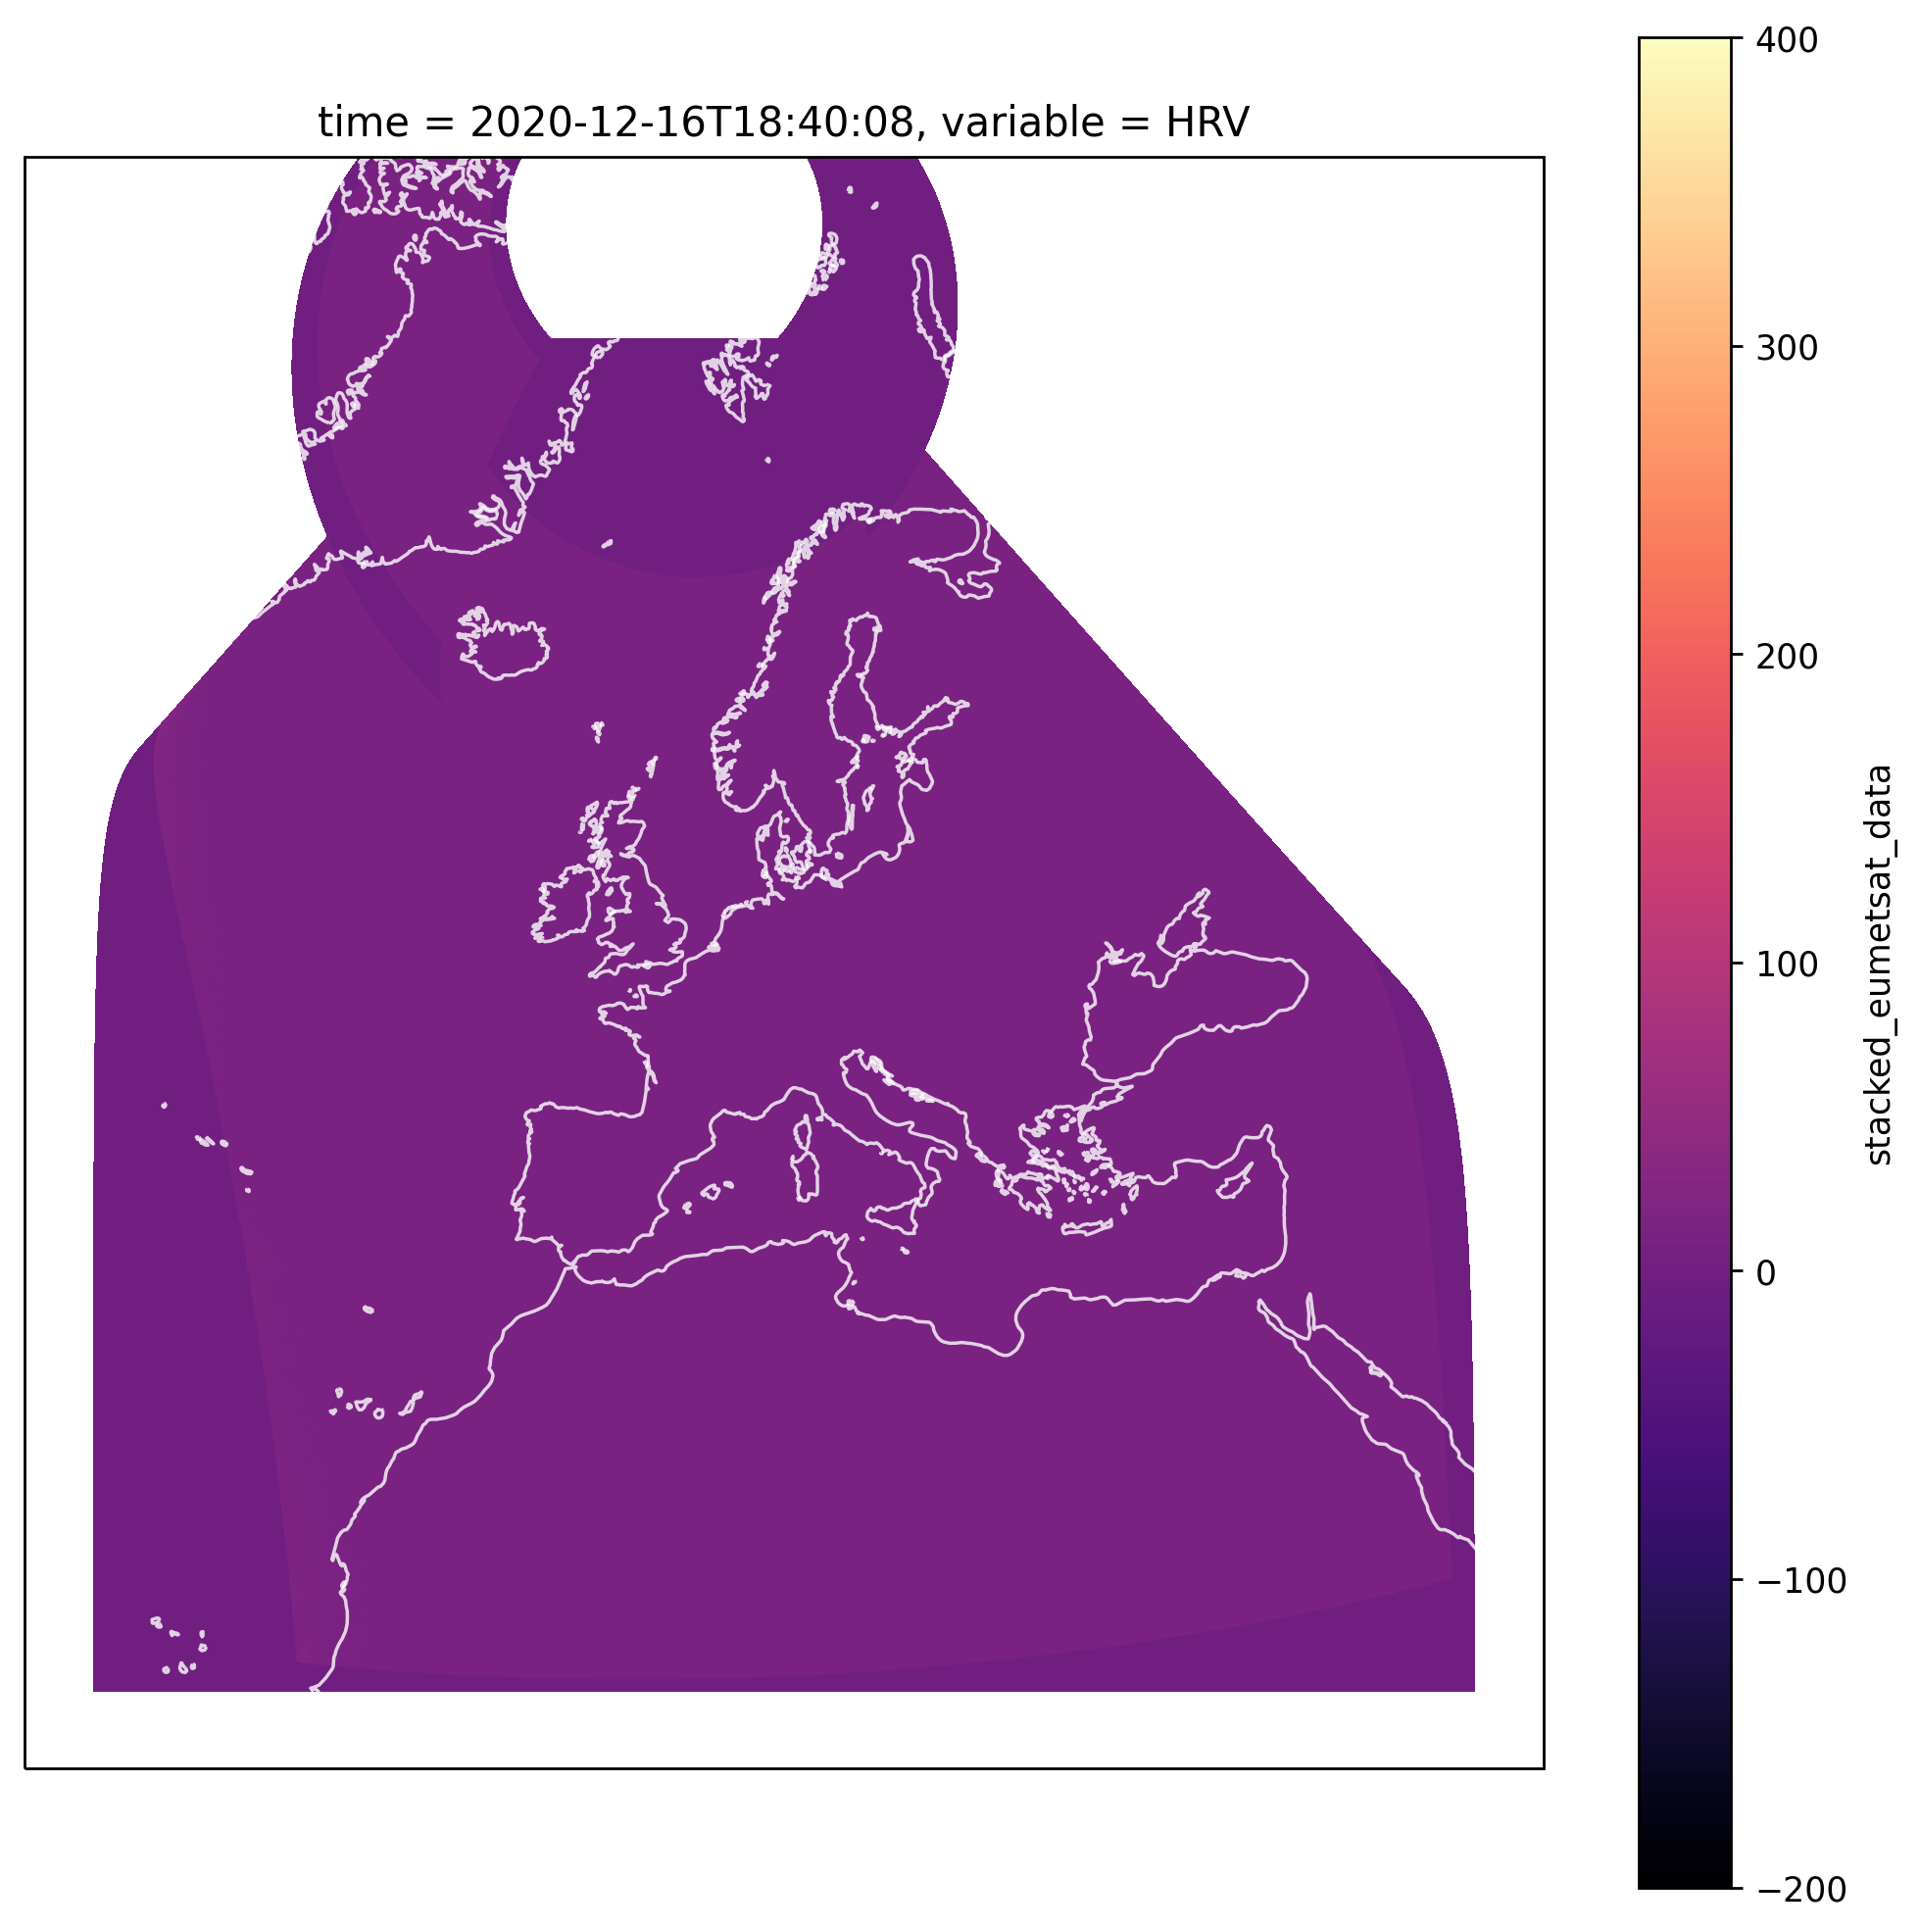

In [19]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

loaded_xarray['stacked_eumetsat_data'].isel(variable=0, time=0).T.plot(ax=ax, cmap='magma', vmin=-200, vmax=400)

ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

We can also identify missing datasets which will be useful for filling them in later

In [20]:
#exports
def identifying_missing_datasets(start_date='', end_date='', eumetsat_zarr_bucket='solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/full_extent_TM_int16'):
    # Identifying date range if not fully provided
    if (start_date == '') or (end_date == ''):
        ds_eumetsat = load_from_zarr_bucket(eumetsat_zarr_bucket)
        start_date = ds_eumetsat.time.min().values
        end_date = ds_eumetsat.time.max().values
    
    print(f'Earliest {start_date}, latest {end_date}')
    
    # have to loop this by month for the API
    month_split = pd.date_range("2020-01-01T00:09:15.000000000", "2021-01-08T01:29:15.000000000", freq="M")
    missing_datasets = []
    
    for i in track(range(len(month_split) - 1)):
    
        # Identifying all potential datasets over specified date range
        datasets = eumetsat.identify_available_datasets(month_split[i], month_split[i+1])

        # Extracting the datetime each dataset was finished
        end_dates = [dataset['properties']['date'].split('/')[-1] for dataset in datasets]
        cleaned_end_dates = pd.to_datetime(end_dates).floor(freq='s').tz_convert(None)

        # Identifying missing datasets from the Zarr DB
        ds_eumetsat = load_from_zarr_bucket(eumetsat_zarr_bucket)
        end_dates_to_datasets = dict(zip(cleaned_end_dates, datasets))
        missing_dates = set(cleaned_end_dates) - set(pd.to_datetime(ds_eumetsat.time.values))
        missing_datasets.append([data for date, data in end_dates_to_datasets.items() if date in missing_dates])
    
    return missing_datasets

In [ ]:
missing_datasets = identifying_missing_datasets()

JSON(missing_datasets)

Earliest 2020-01-01T00:09:15.000000000, latest 2021-01-08T01:29:15.000000000


 [████████████████############################################] 3/11 [00:18<00:06, 6.02s/it]

In [ ]:
JSON(missing_datasets)

In [28]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_utils.ipynb.
Converted 01_eumetsat.ipynb.
Converted 02_reprojection.ipynb.
Converted 03_zarr.ipynb.
Converted 04_gcp.ipynb.
Converted 05_pipeline.ipynb.
Converted 101_downloading.ipynb.
Converted 102_reprojecting.ipynb.
Converted 103_loading.ipynb.
